In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [2]:
fold0=pd.read_table('data/data1/fold_0_data.txt')
fold1=pd.read_table('data/data1/fold_1_data.txt')
fold2=pd.read_table('data/data1/fold_2_data.txt')
fold3=pd.read_table('data/data1/fold_3_data.txt')
fold4=pd.read_table('data/data1/fold_4_data.txt')

In [3]:
df = pd.concat([fold0, fold1, fold2, fold3, fold4], ignore_index=True)
print(df.shape)
df.info()

(19370, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


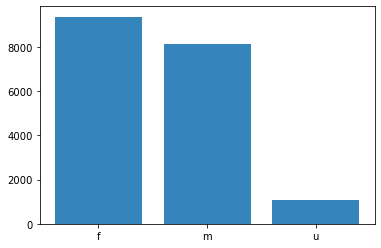

In [4]:
#bar chart
gender = ['f','m','u']
plt.bar(gender, df.gender.value_counts(), align='center', alpha=0.9)
plt.show()

In [5]:
df.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


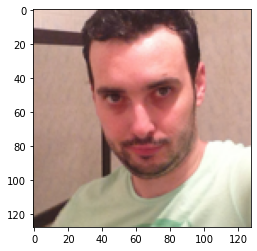

In [6]:
path = "data/data1/faces/"+df.user_id.loc[1]+"/coarse_tilt_aligned_face."+str(df.face_id.loc[1])+"."+df.original_image.loc[1]
image = load_img(path)
image = image.resize((128, 128)) 
plt.imshow(image)
plt.show()

In [7]:
imp_data = df[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
imp_data.info()

img_path = []
for row in df.iterrows():
    path = "data/data1/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

imp_data['img_path'] = img_path
imp_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     19370 non-null  object
 1   gender  18591 non-null  object
 2   x       19370 non-null  int64 
 3   y       19370 non-null  int64 
 4   dx      19370 non-null  int64 
 5   dy      19370 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 908.1+ KB


,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",f,0,414,1086,1383,data/data1/faces/30601258@N03/coarse_tilt_alig...
1,"(25, 32)",m,301,105,640,641,data/data1/faces/30601258@N03/coarse_tilt_alig...
2,"(25, 32)",f,2395,876,771,771,data/data1/faces/30601258@N03/coarse_tilt_alig...
3,"(25, 32)",m,752,1255,484,485,data/data1/faces/30601258@N03/coarse_tilt_alig...
4,"(25, 32)",m,175,80,769,768,data/data1/faces/30601258@N03/coarse_tilt_alig...


In [8]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]
age_mapping_dict = {i[0]: i[1] for i in age_mapping}
age_mapping_dict

{'(0, 2)': '0-2',
 '2': '0-2',
 '3': '0-2',
 '(4, 6)': '4-6',
 '(8, 12)': '8-13',
 '13': '8-13',
 '22': '15-20',
 '(8, 23)': '15-20',
 '23': '25-32',
 '(15, 20)': '15-20',
 '(25, 32)': '25-32',
 '(27, 32)': '25-32',
 '32': '25-32',
 '34': '25-32',
 '29': '25-32',
 '(38, 42)': '38-43',
 '35': '38-43',
 '36': '38-43',
 '42': '48-53',
 '45': '38-43',
 '(38, 43)': '38-43',
 '(38, 48)': '48-53',
 '46': '48-53',
 '(48, 53)': '48-53',
 '55': '48-53',
 '56': '48-53',
 '(60, 100)': '60+',
 '57': '60+',
 '58': '60+'}

In [9]:
drop_labels = []
for idx, each in enumerate(imp_data.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        imp_data.age.loc[idx] = age_mapping_dict[each]

imp_data = imp_data.drop(labels=drop_labels, axis=0) #droped None values
imp_data.age.value_counts(dropna=False)

/home/pj/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [10]:
imp_data = imp_data.dropna()
clean_data = imp_data[imp_data.gender != 'u'].copy()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [11]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

clean_data['gender'] = clean_data['gender'].apply(lambda g: gender_to_label_map[g])
clean_data.head()

,age,gender,x,y,dx,dy,img_path
0,25-32,0,0,414,1086,1383,data/data1/faces/30601258@N03/coarse_tilt_alig...
1,25-32,1,301,105,640,641,data/data1/faces/30601258@N03/coarse_tilt_alig...
2,25-32,0,2395,876,771,771,data/data1/faces/30601258@N03/coarse_tilt_alig...
3,25-32,1,752,1255,484,485,data/data1/faces/30601258@N03/coarse_tilt_alig...
4,25-32,1,175,80,769,768,data/data1/faces/30601258@N03/coarse_tilt_alig...


In [12]:
age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

clean_data['age'] = clean_data['age'].apply(lambda age: age_to_label_map[age])
clean_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,data/data1/faces/30601258@N03/coarse_tilt_alig...
1,4,1,301,105,640,641,data/data1/faces/30601258@N03/coarse_tilt_alig...
2,4,0,2395,876,771,771,data/data1/faces/30601258@N03/coarse_tilt_alig...
3,4,1,752,1255,484,485,data/data1/faces/30601258@N03/coarse_tilt_alig...
4,4,1,175,80,769,768,data/data1/faces/30601258@N03/coarse_tilt_alig...


In [16]:
np.random.choice(df.age, 2)

array(['(15, 20)', '(25, 32)'], dtype=object)

In [18]:
def get_rows(column, value, qtty):
    to_delete = clean_data.age[clean_data[column] == value].index
    to_delete = np.random.choice(to_delete, qtty)
    return to_delete

var25 = get_rows('age', 4, 5000)
var38= get_rows('age', 5, 1776)
var0= get_rows('age', 0, 1776)
var8= get_rows('age', 2, 1276)
var4= get_rows('age', 1, 1276)

In [20]:
rows = np.concatenate((var25, var38, var0, var8, var4), axis=0)

In [21]:
clean_data = clean_data.drop(index=rows).reset_index()
clean_data = clean_data.drop(columns='index')

In [22]:
clean_data.age.value_counts()

4    2079
3    1790
5    1470
2    1312
1    1189
6     909
7     895
0     410
Name: age, dtype: int64

In [23]:
clean_data

,age,gender,x,y,dx,dy,img_path
0,4,0,2395,876,771,771,data/data1/faces/30601258@N03/coarse_tilt_alig...
1,4,1,752,1255,484,485,data/data1/faces/30601258@N03/coarse_tilt_alig...
2,4,1,175,80,769,768,data/data1/faces/30601258@N03/coarse_tilt_alig...
3,4,0,0,422,1332,1498,data/data1/faces/30601258@N03/coarse_tilt_alig...
4,4,0,1069,581,1575,1575,data/data1/faces/30601258@N03/coarse_tilt_alig...
...,...,...,...,...,...,...,...
10049,5,1,402,514,156,156,data/data1/faces/10058630@N06/coarse_tilt_alig...
10050,3,0,841,263,128,129,data/data1/faces/10058630@N06/coarse_tilt_alig...
10051,3,0,841,263,128,129,data/data1/faces/10058630@N06/coarse_tilt_alig...
10052,6,1,913,621,189,187,data/data1/faces/101515718@N03/coarse_tilt_ali...


# Age Modele

In [24]:
X = clean_data[['img_path']]
y = clean_data[['age']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((128, 128))   # Resize the image
    data = np.asarray(image) 
    train_images.append(data)

print('train done...')

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((128, 128))  # Resize the image
    data = np.asarray(image) 
    test_images.append(data)

print('normalizing...')
train_images = np.asarray(train_images) / 255
test_images = np.asarray(test_images) / 255

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train data shape (7037, 1)
Test data shape (3017, 1)
train done...
normalizing...
Train images shape (7037, 128, 128, 3)
Test images shape (3017, 128, 128, 3)


In [25]:
model = Sequential([
    Conv2D(8, 3, padding='same', strides=2, activation='relu', input_shape=(128, 128, 3)),
#     MaxPooling2D(),
#     Dropout(0.3),
    
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
#     Dropout(0.35),
    
    Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.45),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
#     Dropout(0.5),
    
    Flatten(),
    Dense(8, activation = 'softmax')
])

#model.compile(optimizer='adam', loss= tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

2021-11-14 18:12:56.837580: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-14 18:12:56.838410: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-14 18:12:56.839649: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [74]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Callback for earlystopping
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#history = model.fit(train_images, y_train, batch_size=512, epochs=25, validation_data=(test_images, y_test), callbacks=[callback])
history = model.fit(train_images, y_train, epochs=500, validation_data=(test_images, y_test), callbacks=[callback])
model.save('data/age_model_14_11_2021.h5')

test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

Epoch 1/500
220/220 [==============================] - 40s 181ms/step - loss: 0.7380 - accuracy: 0.7510 - val_loss: 1.9359 - val_accuracy: 0.4279
Epoch 2/500
220/220 [==============================] - 40s 181ms/step - loss: 0.5203 - accuracy: 0.8116 - val_loss: 2.0770 - val_accuracy: 0.4292
Epoch 3/500
220/220 [==============================] - 39s 176ms/step - loss: 0.4561 - accuracy: 0.8421 - val_loss: 2.3707 - val_accuracy: 0.4379
Epoch 4/500
220/220 [==============================] - 39s 178ms/step - loss: 0.3702 - accuracy: 0.8758 - val_loss: 2.6490 - val_accuracy: 0.4465
Epoch 5/500
220/220 [==============================] - 40s 181ms/step - loss: 0.2856 - accuracy: 0.8972 - val_loss: 2.6138 - val_accuracy: 0.4200
Epoch 6/500
220/220 [==============================] - 41s 186ms/step - loss: 0.2811 - accuracy: 0.9005 - val_loss: 2.7274 - val_accuracy: 0.4650
Epoch 7/500
220/220 [==============================] - 40s 181ms/step - loss: 0.1774 - accuracy: 0.9399 - val_loss: 3.0320 -

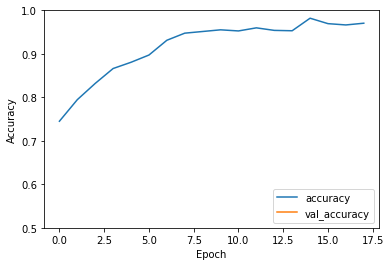

In [75]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

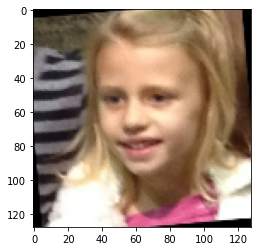

In [76]:
image_path = X_test.img_path[1078]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128)) / 255.0
plt.imshow(image)
plt.show()

In [77]:
X_test.img_path[1078]

'data/data1/faces/29671106@N00/coarse_tilt_aligned_face.194.11192913354_9b4deea81d_o.jpg'

In [78]:
image = np.expand_dims(image, 0)
prediction = model.predict(image)

In [79]:
prediction 

array([[8.7277229e-08, 9.6957976e-01, 2.8817201e-04, 2.9023657e-05,
        5.4932451e-03, 2.9431444e-03, 2.1666525e-02, 8.8682256e-08]],
      dtype=float32)

In [80]:
index = np.argmax(prediction)
decoding = {0:'0-2', 1:'4-6', 2:'8-13',3:'15-20',4:'25-32',5:'38-43',6:'48-53',7:'60+'}

print('[+] prediction is :', decoding[index]) 



[+] prediction is : 4-6


In [81]:
df.iloc[1078]

user_id                              20254529@N04
original_image        9931514636_74e994aab0_o.jpg
face_id                                        17
age                                        (4, 6)
gender                                          f
x                                            1506
y                                             543
dx                                            650
dy                                            650
tilt_ang                                       10
fiducial_yaw_angle                              0
fiducial_score                                 64
Name: 1078, dtype: object

In [82]:
predictions = model.predict(test_images)

In [83]:
predictions[0]

array([1.11629554e-07, 9.66931105e-01, 2.18355781e-04, 2.62904887e-05,
       6.71841437e-03, 2.85177911e-03, 2.32537985e-02, 1.01845075e-07],
      dtype=float32)

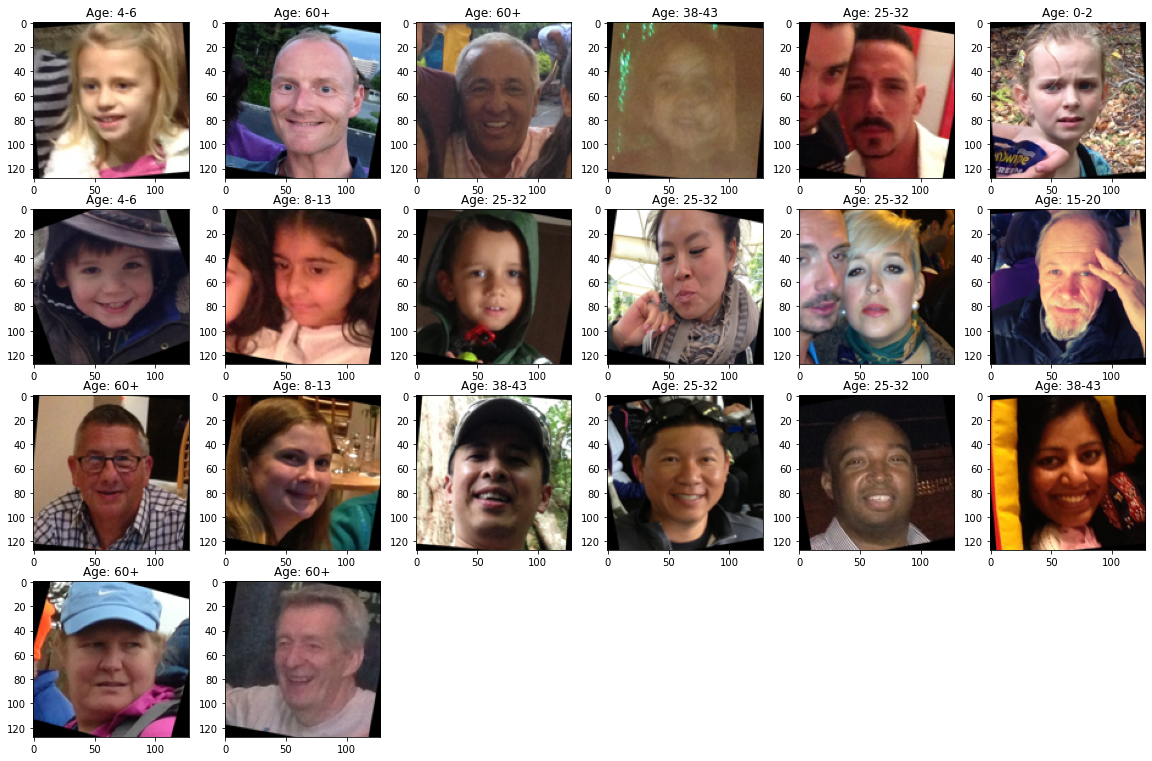

In [84]:
plt.figure(figsize=(20,20))
for row in range(20):
    plt.subplot(6,6,row+1)
    index = np.argmax(predictions[row])
    decoding = {0:'0-2', 1:'4-6', 2:'8-13',3:'15-20',4:'25-32',5:'38-43',6:'48-53',7:'60+'}
    plt.title('Age: ' + decoding[index] )
    plt.imshow(test_images[row])

    